In [1]:
%matplotlib inline
import numpy as np
import os
from lmfit import Parameters, Minimizer
from astropy.io import fits
import scipy.interpolate as interp
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from ctisim.fitting import SimpleModel, SimulatedModel
from ctisim import ITL_AMP_GEOM, SplineTrap
from ctisim.utils import OverscanParameterResults

from ctisim.correction import electronics_operator, trap_operator

error = 7.0/np.sqrt(2000.)
num_transfers = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width
ncols = num_transfers

# Fit Fast Release Component

In [50]:
sensor_id = 'R02_S02'

infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R02/S02/{0}_overscan_results.fits'.format(sensor_id)
hdulist = fits.open(infile)

start = 1
stop = 20
max_signal = 150000.
param_results = OverscanParameterResults.from_fits('{0}_parameter_results.fits'.format(sensor_id))
print(param_results.cti_results)

{1: 4.782903e-07, 2: 6.329077e-07, 3: 1.0901289e-06, 4: 7.722134e-07, 5: 7.109255e-07, 6: 5.848166e-07, 7: 3.7934814e-07, 8: 4.8942115e-06, 9: 5.1227266e-07, 10: 6.065713e-07, 11: 7.649514e-07, 12: 6.3828804e-07, 13: 7.292096e-07, 14: 7.14073e-07, 15: 6.3781766e-07, 16: 4.5771702e-07}


In [51]:
spltraps = {}
for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    ## Second model: model with electronics
    params = Parameters()
    params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=False)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)

    res = np.sum((data-model)[:, :3], axis=1)
    new_signals = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 0]
    rescale = param_results.drift_scales[amp]*new_signals
    new_signals = np.asarray(new_signals - rescale, dtype=np.float64)
    x = new_signals
    y = np.maximum(0, res)

    # Pad left with ramp
    y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
    x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

    # Pad right with constant
    y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
    x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

    f = interp.interp1d(x, y)
    spltrap = SplineTrap(f, 0.4, 1)
    pickle.dump(spltrap, open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'wb'))
    spltraps[amp] = spltrap

# Test Correction

In [52]:
## Correction
corrected = {}
for amp in range(1, 17):
    
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

    imarr = np.zeros((data.shape[0], ncols+data.shape[1]-1))
    ramp = np.tile(signals, (ITL_AMP_GEOM.nx-1, 1)).T
    imarr[:, ITL_AMP_GEOM.prescan_width:ncols-1] = ramp
    imarr[:, ncols-1:] = data

    E = electronics_operator(imarr, param_results.drift_scales[amp],
                             param_results.decay_times[amp],
                             num_previous_pixels=15)

    corrected_electronics = imarr-E

    T = trap_operator(corrected_electronics, spltraps[amp])
    corrected[amp] = corrected_electronics-(1-param_results.cti_results[amp])*T

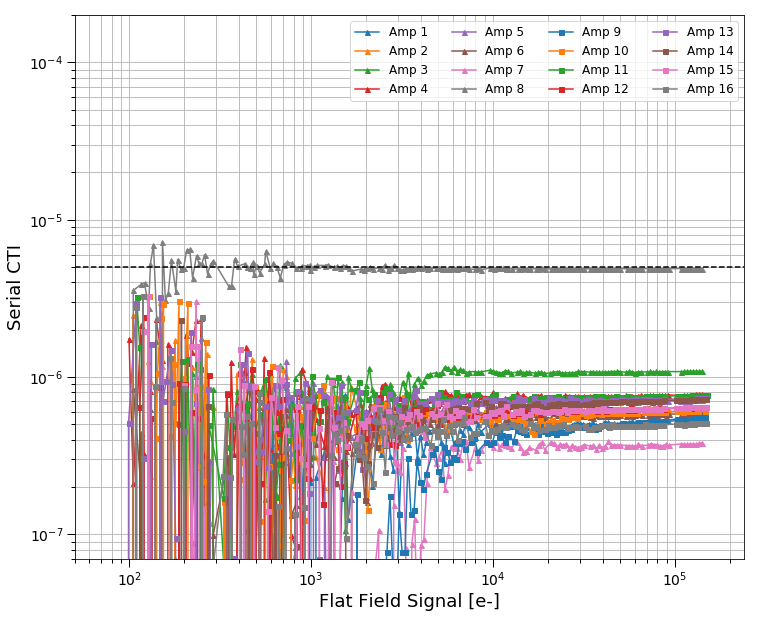

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.get_cmap("tab10")

for amp in range(1, 17):

    if amp > 8: marker='s'
    else: marker = '^'

    signal = np.mean(corrected[amp][:, 50:450], axis=1)
    lastpixel = corrected[amp][:, 511]
    overscan1 = corrected[amp][:, 512]
    overscan2 = corrected[amp][:, 513]
    cti = (overscan1+overscan2)/(num_transfers*lastpixel)

    ax.plot(signal, cti, label='Amp {0}'.format(amp), 
            color = cmap((amp-1)%8), marker=marker, markersize=5)

ax.axhline(y=5.E-6, linestyle='--', color='black')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=4, width=1)
ax.set_ylim(bottom=7E-8, top=2E-4)
ax.set_xlim(left=50.0, right=240000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', axis='both')
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_ylabel('Serial CTI', fontsize=18)
ax.legend(fontsize=12, loc=1, ncol=4)

Text(0.5, 0, 'Flat Field Signal [e-]')

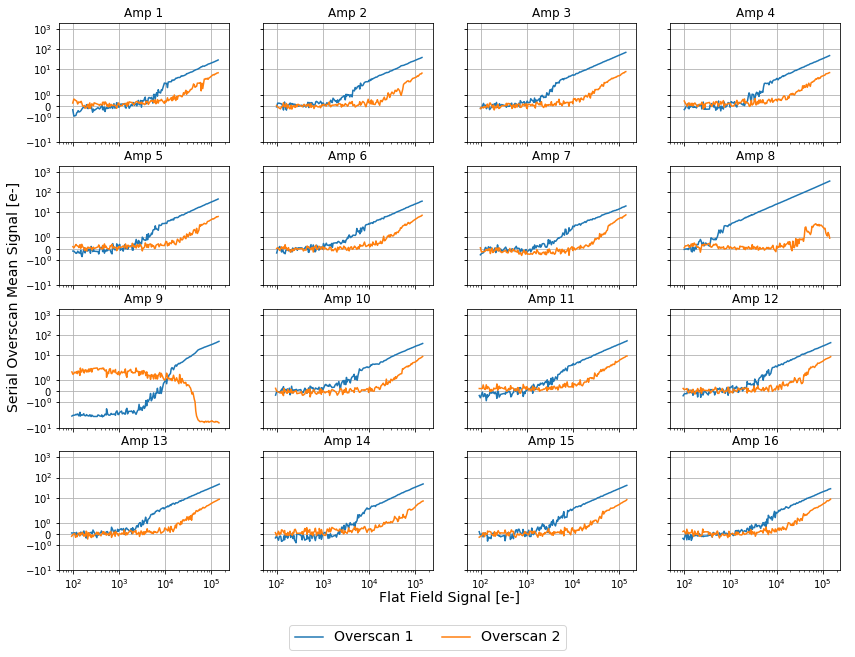

In [54]:
fig, axes = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(14, 10))
axes = axes.flatten()

for amp in range(1, 17):

    signal = np.mean(corrected[amp][:, 50:450], axis=1)
    overscan1 = corrected[amp][:, 512]
    overscan2 = corrected[amp][:, 513]

    axes[amp-1].plot(signal, overscan1, label='Overscan 1'.format(amp))
    axes[amp-1].plot(signal, overscan2, label='Overscan 2'.format(amp))

    axes[amp-1].set_yscale('symlog', threshold=1.0)
    axes[amp-1].set_xscale('log')
    axes[amp-1].set_ylim(bottom=-10.0, top=2000.)
    axes[amp-1].set_xlim(left=50, right=240000)
    axes[amp-1].set_title('Amp {0}'.format(amp), fontsize=12)
    axes[amp-1].grid(True, which='major', axis='both')

h, l = axes[-1].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.12)
fig.legend(h, l, loc='lower center', ncol=2, fontsize=14)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, 
                left=False, right=False)
plt.ylabel('Serial Overscan Mean Signal [e-]', fontsize=14, labelpad=15)
plt.xlabel('Flat Field Signal [e-]', fontsize=14)

# Check Problem Amplifiers

In [50]:
amp = 13

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Second model: model with electronics
params = Parameters()
params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=False)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)
print(params)

res = np.sum((data-model)[:, :2], axis=1)

rescale = param_results.drift_scales[amp]*signals
new_signals = np.asarray(signals - rescale, dtype=np.float64)
x = new_signals
y = np.maximum(0, res)

# Pad left with ramp
y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

# Pad right with constant
y = np.pad(y, (0, 1), 'constant', constant_values=(0, y[-1]))
x = np.pad(x, (0, 1), 'constant', constant_values=(0, 200000.))

f = interp.interp1d(x, y)
spltrap = SplineTrap(f, 0.4, 1)

Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.1371474 (fixed), bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.35 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.0001589736 (fixed), bounds=[0.0:0.001]>), ('decaytime', <Parameter 'decaytime', value=2.5343063 (fixed), bounds=[0.1:4.0]>)])


In [51]:
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 1:]

imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
imarr[:, ncols:] = data

E = electronics_operator(imarr, param_results.drift_scales[amp],
                         param_results.decay_times[amp],
                         num_previous_pixels=15)

corrected_electronics = imarr-E

T, R, C = trap_operator(corrected_electronics, spltrap)
corrected = corrected_electronics-T

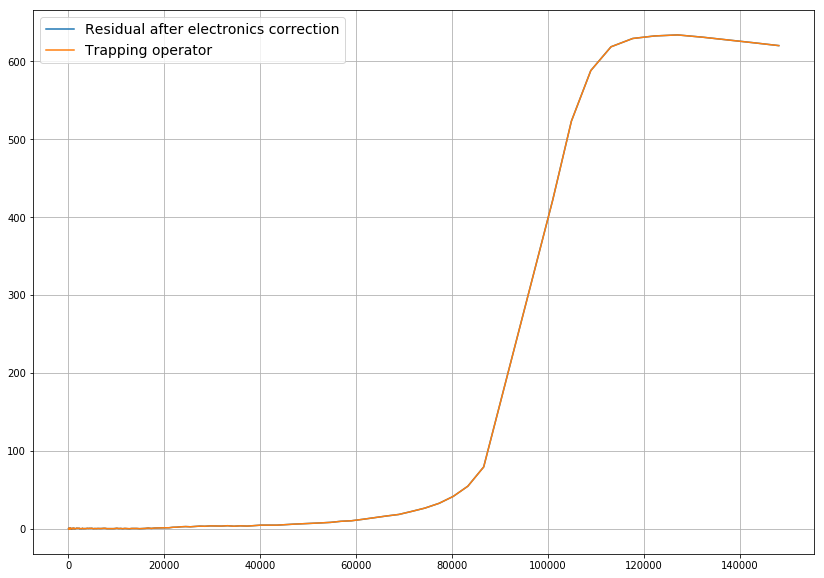

In [54]:
s = np.logspace(2, np.log10(170000.), 500)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(new_signals, res, label='Residual after electronics correction')
ax.plot(new_signals, T[:, 512], label='Trapping operator')
#ax.plot(corrected_electronics[:, 511], spltrap.f(corrected_electronics[:, 511]), label='Trapping from last pixel')
ax.legend(fontsize=14)
ax.grid(which='both', axis='both')

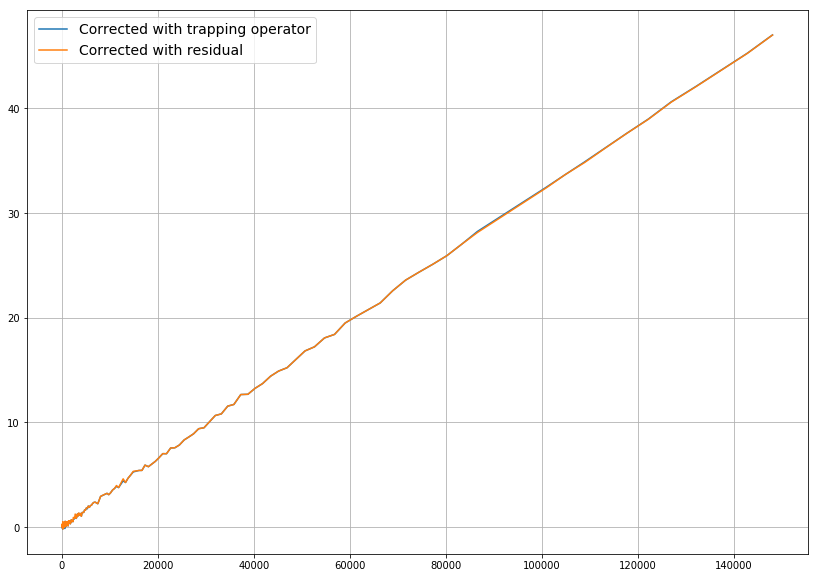

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(new_signals, corrected_electronics[:, 512]-T[:, 512], label='Corrected with trapping operator')
ax.plot(new_signals, corrected_electronics[:, 512]-res, label='Corrected with residual')
ax.legend(fontsize=14)
ax.grid(which='both', axis='both')

# Test Results Generated By Script

{1: 4.782903e-07, 2: 6.329077e-07, 3: 1.0901289e-06, 4: 7.722134e-07, 5: 7.109255e-07, 6: 5.848166e-07, 7: 3.7934814e-07, 8: 4.8942115e-06, 9: 5.1227266e-07, 10: 6.065713e-07, 11: 7.649514e-07, 12: 6.3828804e-07, 13: 7.292096e-07, 14: 7.14073e-07, 15: 6.3781766e-07, 16: 4.5771702e-07}


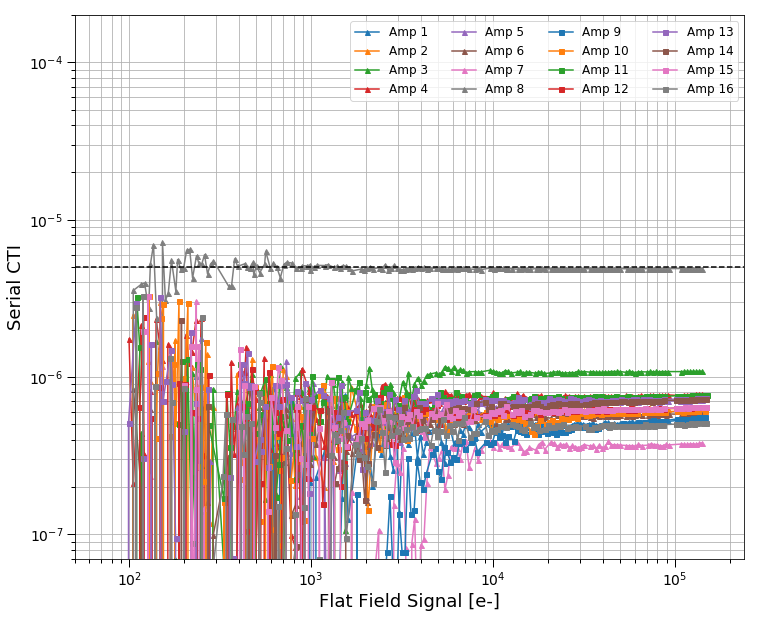

In [58]:
main_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R02/S02/'
results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/test2/'
#results_dir ='/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/lsst-camera-dh/ctisim/notebooks/'
sensor_id = 'R02_S02'

infile = os.path.join(main_dir, '{0}_overscan_results.fits'.format(sensor_id))
hdulist = fits.open(infile)

start = 1
stop = 20
max_signal = 150000.
param_results = OverscanParameterResults.from_fits(os.path.join(results_dir, 
                                                                '{0}_parameter_results.fits'.format(sensor_id)))
print(param_results.cti_results)


## Correction
corrected = {}
for amp in range(1, 17):
    
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

    imarr = np.zeros((data.shape[0], ncols+data.shape[1]-1))
    ramp = np.tile(signals, (ITL_AMP_GEOM.nx-1, 1)).T
    imarr[:, ITL_AMP_GEOM.prescan_width:ncols-1] = ramp
    imarr[:, ncols-1:] = data

    E = electronics_operator(imarr, param_results.drift_scales[amp],
                             param_results.decay_times[amp],
                             num_previous_pixels=15)

    corrected_electronics = imarr-E
    
    trap_file = os.path.join(results_dir, 
                             '{0}_amp{1}_traps.pkl'.format(sensor_id, amp))
    spltrap = pickle.load(open(trap_file, 'rb'))

    T = trap_operator(corrected_electronics, spltrap)
    corrected[amp] = corrected_electronics-(1-param_results.cti_results[amp])*T
    
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.get_cmap("tab10")

for amp in range(1, 17):

    if amp > 8: marker='s'
    else: marker = '^'

    signal = np.mean(corrected[amp][:, 50:450], axis=1)
    lastpixel = corrected[amp][:, 511]
    overscan1 = corrected[amp][:, 512]
    overscan2 = corrected[amp][:, 513]
    cti = (overscan1+overscan2)/(num_transfers*lastpixel)

    ax.plot(signal, cti, label='Amp {0}'.format(amp), 
            color = cmap((amp-1)%8), marker=marker, markersize=5)

ax.axhline(y=5.E-6, linestyle='--', color='black')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=4, width=1)
ax.set_ylim(bottom=7E-8, top=2E-4)
ax.set_xlim(left=50.0, right=240000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', axis='both')
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_ylabel('Serial CTI', fontsize=18)
ax.legend(fontsize=12, loc=1, ncol=4)

In [59]:
param_results1 = OverscanParameterResults.from_fits('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/lsst-camera-dh/ctisim/notebooks/R02_S02_parameter_results.fits')
param_results2 = OverscanParameterResults.from_fits('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/test/R02_S02_parameter_results.fits')

print(param_results1.drift_scales)
print(param_results2.drift_scales)

print(param_results1.decay_times)
print(param_results2.decay_times)

{1: 0.0001823858, 2: 0.00016140462, 3: 0.00016521335, 4: 0.000167557, 5: 0.00017700442, 6: 0.00017055054, 7: 0.00014558305, 8: 0.0001319785, 9: 0.00044687185, 10: 0.00017508042, 11: 0.000163108, 12: 0.000159876, 13: 0.0001589736, 14: 0.0001967267, 15: 0.00016851662, 16: 0.00015319066}
{1: 0.0001823858, 2: 0.00016140462, 3: 0.00016521335, 4: 0.000167557, 5: 0.00017700442, 6: 0.00017055054, 7: 0.00014558305, 8: 0.0001319785, 9: 0.00044687185, 10: 0.00017508042, 11: 0.000163108, 12: 0.000159876, 13: 0.0001589736, 14: 0.0001967267, 15: 0.00016851662, 16: 0.00015319066}
{1: 2.6115127, 2: 2.633344, 3: 2.5267427, 4: 2.547606, 5: 2.4970033, 6: 2.5518136, 7: 2.7400863, 8: 2.2268283, 9: 1.7036829, 10: 2.5600224, 11: 2.5666173, 12: 2.522648, 13: 2.5343063, 14: 2.4057436, 15: 2.5707982, 16: 2.7179036}
{1: 2.6115127, 2: 2.633344, 3: 2.5267427, 4: 2.547606, 5: 2.4970033, 6: 2.5518136, 7: 2.7400863, 8: 2.2268283, 9: 1.7036829, 10: 2.5600224, 11: 2.5666173, 12: 2.522648, 13: 2.5343063, 14: 2.4057436, 